In [122]:
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import matplotlib.pyplot as plt

In [123]:
df = pd.read_csv("../data/housing.csv")
df = df.sample(frac=0.1, random_state=42)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


In [124]:
df["ocean_proximity"].unique()

array(['INLAND', 'NEAR BAY', '<1H OCEAN', 'NEAR OCEAN'], dtype=object)

In [125]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore')
X_ohe = ohe.fit_transform(df["ocean_proximity"].values.reshape(-1,1))
X_ohe = pd.DataFrame(X_ohe.toarray(), columns=ohe.get_feature_names_out())
X_ohe.head()

,x0_<1H OCEAN,x0_INLAND,x0_NEAR BAY,x0_NEAR OCEAN
0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0


In [126]:
df_ohe = pd.concat([df, X_ohe], axis=1)
df_ohe = df_ohe.drop("ocean_proximity", axis=1)
df_ohe = df_ohe.dropna()
df_ohe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,x0_<1H OCEAN,x0_INLAND,x0_NEAR BAY,x0_NEAR OCEAN
1901,-119.99,38.88,17.0,2807.0,529.0,675.0,251.0,2.7457,107800.0,0.0,1.0,0.0,0.0
474,-122.28,37.86,52.0,2031.0,450.0,958.0,445.0,1.9327,169900.0,1.0,0.0,0.0,0.0
1290,-121.79,38.00,34.0,3090.0,593.0,1588.0,566.0,3.6118,124700.0,1.0,0.0,0.0,0.0
408,-122.28,37.90,52.0,2318.0,328.0,779.0,312.0,7.1754,362900.0,0.0,1.0,0.0,0.0
385,-122.29,37.90,49.0,1283.0,238.0,576.0,236.0,3.3333,276800.0,1.0,0.0,0.0,0.0


In [127]:
y = df_ohe["median_house_value"]
X =  df_ohe.loc[:, df_ohe.columns != "median_house_value"]

In [128]:
X.shape

(162, 12)

In [129]:
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
X_std = sc_X.fit_transform(X)
sc_y = StandardScaler()
y_std = sc_y.fit_transform(y.values.reshape(-1,1))

In [130]:
kernel = 1.0 * RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0)

In [131]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_std, y_std, random_state=42, train_size=0.8)

In [132]:
gpr.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0,
                         kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1))

In [133]:
y_pred_train_mean, y_pred_train_std = gpr.predict(X_train, return_std=True)
y_pred_test_mean, y_pred_test_std = gpr.predict(X_test, return_std=True)


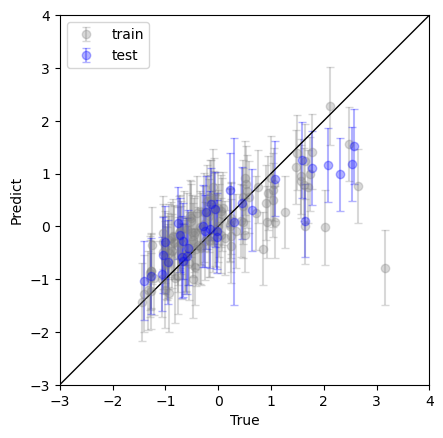

In [134]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(y_train, y_pred_train_mean, yerr=y_pred_train_std, linestyle='None', capsize=3, marker='o', color='gray', alpha=0.3, label='train')
ax.errorbar(
    y_test,
    y_pred_test_mean,
    yerr=y_pred_test_std,
    linestyle="None",
    capsize=3,
    marker="o",
    color="blue",
    alpha=0.3,
    label="test",
)
ax.plot([-3,4], [-3, 4], color="black", linewidth=1.0)
ax.legend()
ax.set_xlim(-3, 4)
ax.set_ylim(-3, 4)
ax.set_xlabel("True")
ax.set_ylabel("Predict")
ax.set_aspect("equal")

In [135]:
import numpy as np
n_samples = 100
candidates = []
X_col = [c for c in df.columns if c != "median_house_value"]
for _ in range(n_samples):
    candidate = {}
    for col in X_col:
        if df[col].dtypes == "float64":
            value_grid = np.linspace(X[col].min(), df[col].max(), 10)
            value = np.random.choice(value_grid)
        else:
            value = np.random.choice(df[col].unique())
        candidate[col] = value
    candidates.append(candidate)

X_candidates = pd.DataFrame(candidates)

In [136]:
X_candidates

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-122.023333,37.267778,52.000000,24121.000000,2431.777778,9336.666667,3841.555556,13.424222,INLAND
1,-115.643333,40.106667,35.333333,10778.777778,42.000000,86.000000,3841.555556,15.000100,INLAND
2,-115.643333,41.810000,29.777778,24121.000000,5419.000000,86.000000,4930.000000,10.272467,<1H OCEAN
3,-119.896667,40.106667,35.333333,21452.555556,3029.222222,9336.666667,2753.111111,8.696589,<1H OCEAN
4,-122.023333,38.403333,18.666667,24121.000000,42.000000,2398.666667,32.000000,11.848344,NEAR BAY
...,...,...,...,...,...,...,...,...,...
95,-124.150000,37.835556,7.555556,13447.222222,1236.888889,9336.666667,2753.111111,15.000100,NEAR OCEAN
96,-123.086667,36.700000,2.000000,105.000000,3626.666667,86.000000,2208.888889,7.120711,NEAR OCEAN
97,-115.643333,38.971111,7.555556,10778.777778,1236.888889,86.000000,1664.666667,3.968956,NEAR OCEAN
98,-120.960000,40.674444,18.666667,5441.888889,2431.777778,1242.333333,32.000000,11.848344,NEAR OCEAN


In [137]:
X_candidates_ohe = ohe.fit_transform(X_candidates["ocean_proximity"].values.reshape(-1, 1))
X_candidates_ohe = pd.DataFrame(X_candidates_ohe.toarray(), columns=ohe.get_feature_names_out())
X_candidates_ohe

,x0_<1H OCEAN,x0_INLAND,x0_NEAR BAY,x0_NEAR OCEAN
0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
95,0.0,0.0,0.0,1.0
96,0.0,0.0,0.0,1.0
97,0.0,0.0,0.0,1.0
98,0.0,0.0,0.0,1.0


In [138]:
X_candidates_ohe = pd.concat([X_candidates, X_candidates_ohe], axis=1)
X_candidates_ohe = X_candidates_ohe.drop("ocean_proximity", axis=1)
X_candidates_std = sc_X.transform(X_candidates_ohe)

In [139]:
y_pred_mean, y_pred_std = gpr.predict(X_candidates_std, return_std=True)

In [140]:
y_pred_mean_real = sc_y.inverse_transform(y_pred_mean.reshape(-1, 1)).flatten()
y_pred_std_real = sc_y.inverse_transform(y_pred_std.reshape(-1, 1)).flatten()
y_pred = pd.DataFrame({"y_mean":y_pred_mean_real, "y_std":y_pred_std_real})

In [141]:
print(y_pred_mean_real.min(), y_pred_mean_real.max())

74091.0852936964 402297.07535339706


In [142]:
data_candidate = pd.concat([X_candidates, y_pred], axis=1)
kappa = 0.1
data_candidate["UCB"] = data_candidate["y_mean"] + kappa*data_candidate["y_std"]

In [143]:
data_candidate.sort_values("UCB", ascending=False)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,y_mean,y_std,UCB
52,-116.706667,37.267778,35.333333,2773.444444,3029.222222,86.000000,2208.888889,15.000100,INLAND,402297.075353,388810.719198,441178.147273
96,-123.086667,36.700000,2.000000,105.000000,3626.666667,86.000000,2208.888889,7.120711,NEAR OCEAN,402222.733336,377058.355286,439928.568864
50,-124.150000,38.971111,2.000000,5441.888889,5419.000000,86.000000,2208.888889,13.424222,NEAR OCEAN,390871.592989,430146.983126,433886.291302
16,-123.086667,40.106667,46.444444,16115.666667,4224.111111,1242.333333,2753.111111,11.848344,NEAR OCEAN,385793.677077,404040.848808,426197.761958
98,-120.960000,40.674444,18.666667,5441.888889,2431.777778,1242.333333,32.000000,11.848344,NEAR OCEAN,385665.942133,335506.990286,419216.641161
...,...,...,...,...,...,...,...,...,...,...,...,...
9,-114.580000,41.242222,2.000000,24121.000000,2431.777778,5867.666667,2208.888889,2.393078,INLAND,105213.952538,422940.435019,147507.996040
91,-118.833333,38.971111,24.222222,8110.333333,3626.666667,9336.666667,2753.111111,2.393078,NEAR BAY,99388.121192,393907.187870,138778.839979
75,-118.833333,40.106667,29.777778,13447.222222,3029.222222,7024.000000,3297.333333,0.817200,NEAR BAY,99568.100014,388702.918768,138438.391890
77,-115.643333,38.971111,29.777778,5441.888889,3626.666667,9336.666667,32.000000,7.120711,NEAR BAY,95278.240195,415631.007654,136841.340961


In [144]:
sc_y.inverse_transform(y_pred_std.reshape(-1, 1))

array([[410444.93675478],
       [420372.407864  ],
       [460094.03292284],
       [391878.79208746],
       [381967.29401908],
       [397402.59630556],
       [397865.23613649],
       [312729.56754426],
       [444471.31818978],
       [422940.43501945],
       [375135.51846494],
       [391835.49778576],
       [340838.34939414],
       [437748.02518627],
       [390228.91935089],
       [427143.63861722],
       [404040.84880751],
       [415675.86575695],
       [458571.46798893],
       [341987.07847625],
       [410151.18325553],
       [434485.16725388],
       [431952.04760309],
       [458794.42530099],
       [401009.09935143],
       [426332.10730254],
       [435618.74462727],
       [399318.253749  ],
       [445571.81230486],
       [432801.74191955],
       [418417.38674904],
       [324957.64574227],
       [443985.73300895],
       [391389.28507617],
       [340005.19501543],
       [373703.09551031],
       [419869.617883  ],
       [433691.36931268],
       [4329

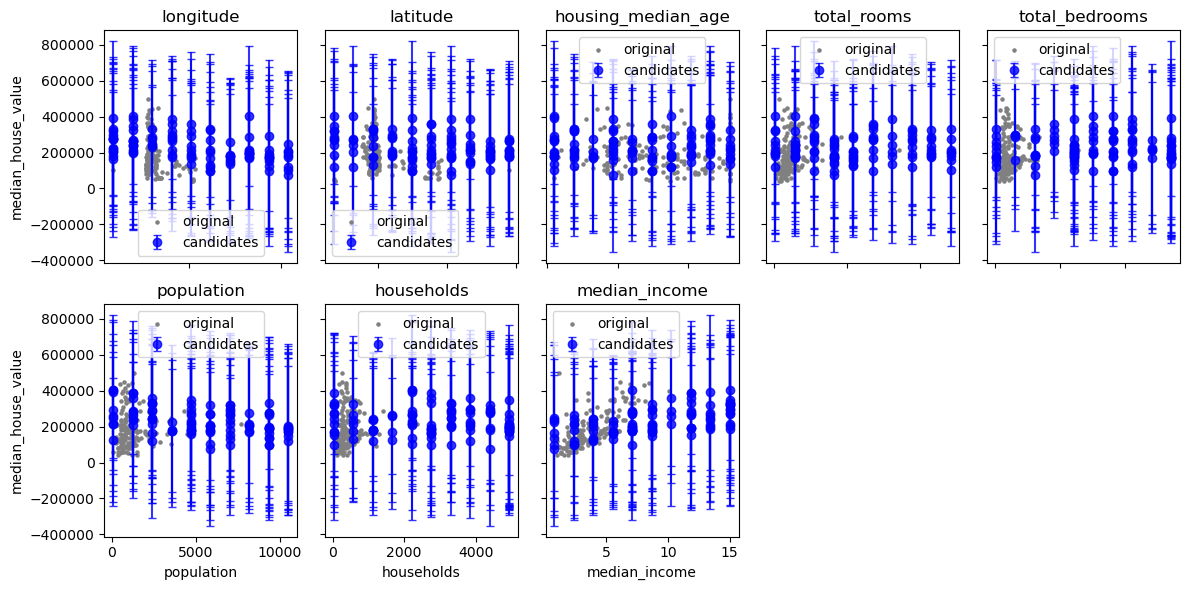

In [145]:
fig = plt.figure(figsize=(12,6))
for i, col in enumerate(X_col):
    if col != "ocean_proximity":
        ax = fig.add_subplot(2, 5, i+1)
        ax.scatter(X[col], y, label="original", color="gray", s=5)
        ax.errorbar(
            X_candidates[col],
            y_pred_mean_real,
            yerr=y_pred_std_real,
            label="candidates",
            capsize=3,
            linestyle="None",
            marker="o",
            color="blue",
            alpha=0.8,
        )
        ax.set_title(col)
        ax.set_xlabel(col)
        ax.set_ylabel("median_house_value")
        ax.label_outer()
        ax.legend()
fig.tight_layout()

In [146]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_std)
X_pc = pca.transform(X_std)

In [147]:
X_candidates_pc = pca.transform(X_candidates_std)

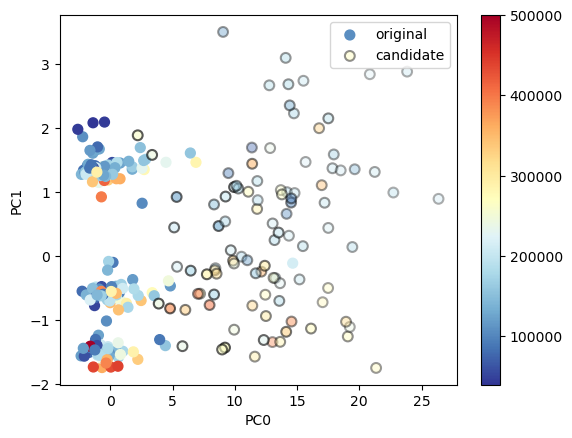

In [148]:
vmin = y.min()
vmax = y.max()

fig = plt.figure()
ax = fig.add_subplot(111)
m = ax.scatter(
    X_pc[:, 0],
    X_pc[:, 1],
    c=list(y.values),
    s=50,
    alpha=1.0,
    cmap="RdYlBu_r",
    vmin=vmin,
    vmax=vmax,
    label="original"
)
ax.scatter(
    X_candidates_pc[:, 0],
    X_candidates_pc[:, 1],
    c=list(y_pred_mean_real),
    s=50,
    alpha=list(1-y_pred_std*0.25),
    cmap="RdYlBu_r",
    vmin=vmin,
    vmax=vmax,
    linewidths=1.5,
    edgecolors="black",
    label="candidate",
)
fig.colorbar(m, ax=ax)
ax.set_xlabel("PC0")
ax.set_ylabel("PC1")
ax.legend()

In [149]:
top5 = data_candidate.sort_values("UCB", ascending=False).iloc[:5]
top5.index

Index([52, 96, 50, 16, 98], dtype='int64')

In [150]:
ax.scatter(
    X_candidates_pc[top5.index, 0],
    X_candidates_pc[top5.index, 1],
    c="green",
    s=300,
    alpha=0.3,
    label="TOP5",
    zorder=0
)
ax.legend()

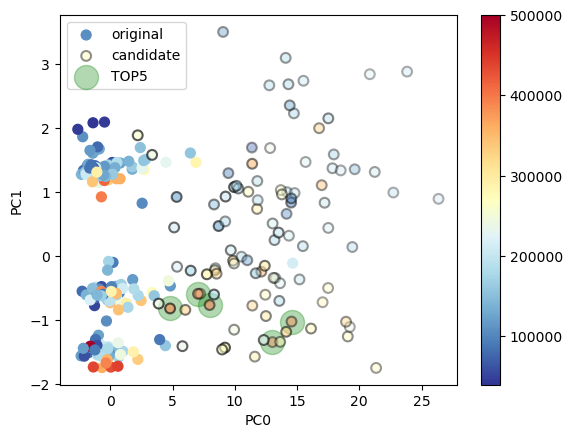

In [151]:
fig